In [8]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy.spatial import distance
from imutils import perspective
from imutils import contours
import imutils

%matplotlib inline

image_folder = "Camera_Calibration/"


In [9]:
board_height = 8
board_width = 6

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((board_height*board_width,3), np.float32)
objp[:,:2] = np.mgrid[0:board_height,0:board_width].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob(image_folder + "IMAG*.jpg")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (board_height, board_width),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (board_height,board_width), corners2,ret)

cv2.destroyAllWindows()

In [10]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

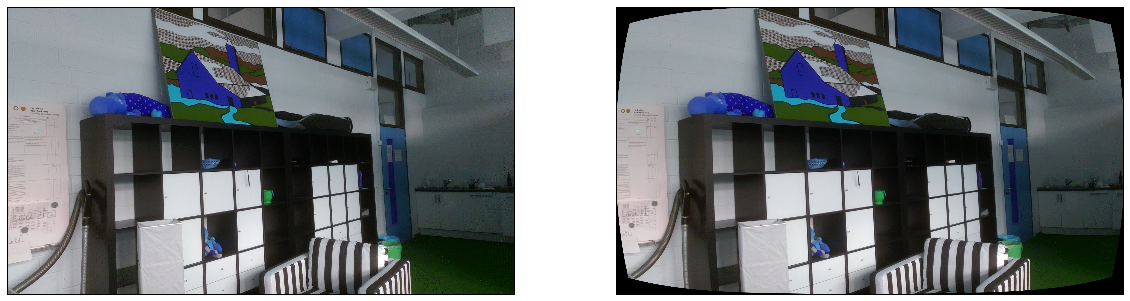

In [11]:
img = cv2.imread(image_folder + 'image_test_calibration.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
undst = cv2.undistort(img, mtx, dist, None, newcameramtx)
cv2.imwrite(image_folder + 'image_test_calibration_new.png',undst)

fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

a = fig.add_subplot(1, 2, 2)
plt.imshow(undst)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [12]:
print("Original camera matrix")
print(mtx)
print("Optimal camera matrix:")
print(newcameramtx)

Original camera matrix
[[  1.89722344e+03   0.00000000e+00   1.32846464e+03]
 [  0.00000000e+00   1.89705077e+03   7.77796386e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Optimal camera matrix:
[[  2.07768970e+03   0.00000000e+00   1.33768404e+03]
 [  0.00000000e+00   1.92533325e+03   7.76704975e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [13]:
# This solution is referred from http://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(image_folder + "image_test_size.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
 
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)
 
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)
pixelsPerMetric = None


In [14]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

# Size of reference lefter most object (10 cent coin) in mm
ref_size = 19.75

orig = image.copy()
# loop over the contours individually
for c in cnts:
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 800:
        continue
 
    # compute the rotated bounding box of the contour
    #orig = image.copy()
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
 
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    box = perspective.order_points(box)
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)

    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
    
    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
        (255, 0, 255), 2)
    cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
        (255, 0, 255), 2)

    # compute the Euclidean distance between the midpoints
    dA = distance.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = distance.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / ref_size
    
    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric

    # draw the object sizes on the image
    cv2.putText(orig, "{:.1f}mm".format(dimA),
        (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (255, 255, 255), 2)
    cv2.putText(orig, "{:.1f}mm".format(dimB),
        (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (255, 255, 255), 2)


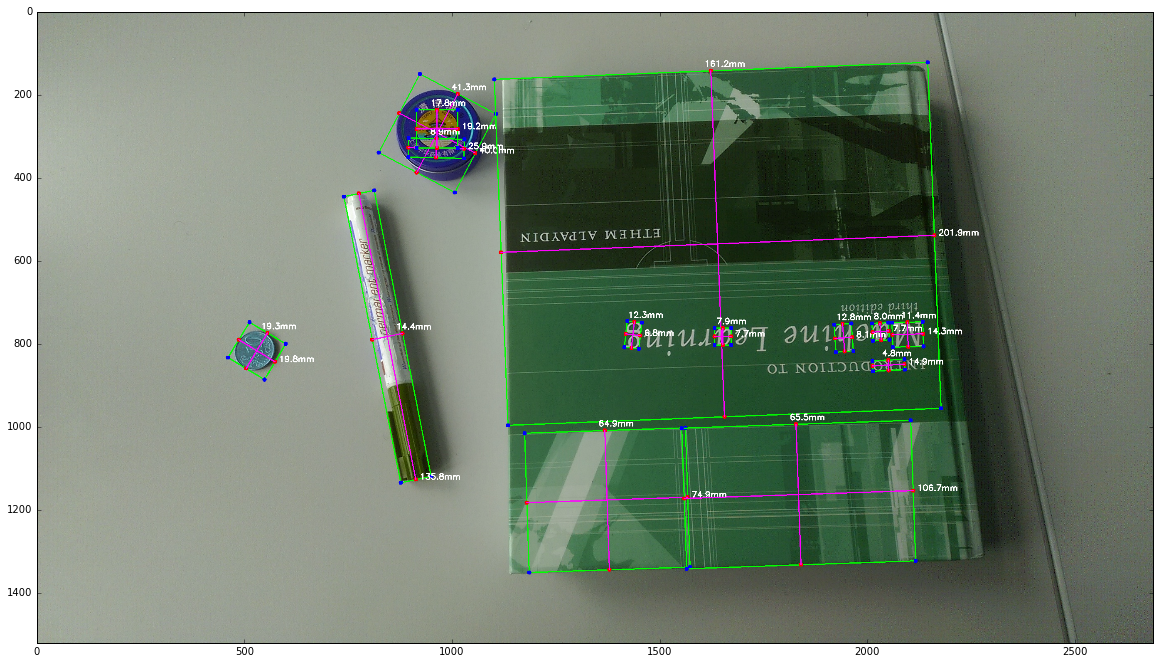

In [15]:
plt.figure(figsize=(20,15))
plt.imshow(orig)

In [53]:
import re

correspondence_folder = "FMatriximages/7/"

stereo_image = cv2.imread(correspondence_folder + "picture-24.jpg")

with open(correspondence_folder + "FMatrixCorrPointsStereo.txt") as f:
    lines = f.readlines()
    coords = [None, None]
    index = 0
    for line in lines:
        if re.match(r"ans =\.*", line):
            index = index + 1
            if index > 2:
                index = 2
        result = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        if len(result) != 2:
            continue
        else:
            result = np.reshape(list(map(float, result)), (1, 2))
            coords[index - 1] = np.append(coords[index - 1], result, axis=0) if coords[index - 1] is not None else result


(61, 2)
